In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
store_100_path = r"df_all_store_100.parquet"
store_42_path = r"df_all_store_42.parquet"
store_4906_path = r"df_all_store_4906.parquet"

In [4]:
df_100 = pd.read_parquet(store_100_path)
df_42 = pd.read_parquet(store_42_path)
df_4906 = pd.read_parquet(store_4906_path)
df_all = pd.concat([df_100, df_42, df_4906])

In [5]:
del df_100, df_42, df_4906

In [10]:
df_all['date'] = pd.to_datetime(df_all['date'])

sku
201999999991001    238.0
100630105000002    126.0
100630368000002    118.0
100080135000001    116.0
100080135000003    115.0
                   ...  
100533453000003     -1.0
100539032000001     -1.0
100548035000001     -1.0
100520165000004     -1.0
100080411000002     -3.0
Name: sales, Length: 22823, dtype: float64

In [7]:
warehouse_path = r"df_all_store_VZ01.parquet"
df_warehouse = pd.read_parquet(warehouse_path)

['100630105000002']

In [14]:
df_warehouse = df_warehouse.rename(columns={"stock": "warehouse_stock"})
df_warehouse['date'] = pd.to_datetime(df_warehouse['date'])

In [8]:
df_all['sku'].nunique()

22823

<Axes: xlabel='date'>

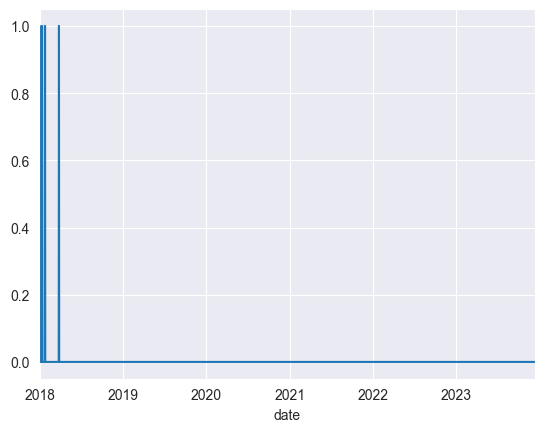

In [15]:
df_warehouse['sku'] = df_warehouse['sku'].astype(str)


In [16]:
df_warehouse = df_warehouse[df_warehouse['date'] > '2018-01-01']

In [17]:
df_all = df_all.merge(df_warehouse[["sku","date","warehouse_stock"]], on = ["sku","date"], how = "left")


In [12]:
df_all = df_all[df_all['date'] > '2018-01-01']

In [18]:
df_all = df_all.sort_values('date')

In [21]:
df_all = df_all.merge(df_all[df_all['stock'] > 0].groupby(['sku', 'store']).agg({'stock': 'first'}).reset_index().rename(columns={'stock':'palmers_first_allocation'}), on = ['sku', 'store'], how = 'left')

In [23]:
sku_store_df_step_g = df_all.groupby(['sku', 'store'])

In [16]:
import json
dict_per_store_per_year_path = r"dict_per_store_per_year.json"
with open(dict_per_store_per_year_path) as json_file:
    dict_per_store_per_year = json.load(json_file)

In [64]:
first_dist_store_100 =  dict_per_store_per_year['2020']['100'] / (dict_per_store_per_year['2020']['100'] + dict_per_store_per_year['2020']['42'] + dict_per_store_per_year['2020']['4906'])
first_dist_store_42 =  dict_per_store_per_year['2020']['42'] / (dict_per_store_per_year['2020']['100'] + dict_per_store_per_year['2020']['42'] + dict_per_store_per_year['2020']['4906'])
first_dist_store_4906 =  dict_per_store_per_year['2020']['4906'] / (dict_per_store_per_year['2020']['100'] + dict_per_store_per_year['2020']['42'] + dict_per_store_per_year['2020']['4906'])

In [65]:
first_dist_store_100, first_dist_store_42

(0.56062424969988, 0.31892002083852405, 0.12045572946159595)

In [54]:
store_100_dist_need_to_be = 51 / 104
store_100_dist_need_to_be

0.40476190476190477

In [55]:
store_42_dist_need_to_be = 53 / 104
store_42_dist_need_to_be

0.42063492063492064

In [1]:
df_all[(df_all['sku'].isin(['100630105000002'])) & (df_all['store'] == '100')]

NameError: name 'df_all' is not defined

In [56]:
i = 0

dict_of_all_data_after_preprocess = {}
for sku in ['100630105000002']:
    dict_of_all_data_after_preprocess[sku] = {}
    for store in ['42', '100']:
        dict_of_all_data_after_preprocess[sku][store] = {}

        sku_store_df_step = sku_store_df_step_g.get_group((sku, store))
        first_stock = sku_store_df_step[sku_store_df_step["stock"]>0]["stock"].iloc[0]
        # nan in our_stock if before first stock
        sku_store_df_step.loc[sku_store_df_step["date"]<sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "palmers_first_allocation"] = np.nan
        sku_store_df_step['days_from_first_stock'] = 1
        sku_store_df_step.loc[sku_store_df_step["date"]<sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "days_from_first_stock"] = np.nan
        sku_store_df_step['days_from_first_stock'] = sku_store_df_step['days_from_first_stock'].cumsum()
        sku_store_df_step['sales_cumsum'] = sku_store_df_step['sales'].cumsum()
        sku_store_df_step['dynamic_stock_with_palmers_init'] = sku_store_df_step['palmers_first_allocation'] - sku_store_df_step['sales_cumsum']
        sku_store_df_step['sales_cumsum_divide_days_from_first_stock'] =  sku_store_df_step['sales_cumsum'] / sku_store_df_step['days_from_first_stock']

        zero_sales_days_back = 1
        sku_store_df_step['days_from_last_sales_that_not_zero'] = 1
        for index, row in sku_store_df_step.shift(1).iterrows():
            # if index is sku_store_df_step[sku_store_df_step["stock"]>0]["stock"] index
            if index > sku_store_df_step[sku_store_df_step["stock"]>0].index[0]:
                if row['sales'] == 0:
                    zero_sales_days_back += 1
                else:
                    zero_sales_days_back = 1
                sku_store_df_step.at[index, 'days_from_last_sales_that_not_zero'] = zero_sales_days_back
        sku_store_df_step.loc[sku_store_df_step["date"]<sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "days_from_last_sales_that_not_zero"] = np.nan
        sku_store_df_step['rate_sales'] = sku_store_df_step['sales'] / sku_store_df_step['days_from_last_sales_that_not_zero']
        dict_of_all_data_after_preprocess[sku][store] = sku_store_df_step
        sku_store_df_step['diff_stock'] = sku_store_df_step['stock'].diff()




0.1746031746031746

In [66]:
print(sku_store_df_step.iloc[100:])

In [67]:

dynamic_distribution_per_store = {}
date = '2021-06-13'
total_stock_warehouse = 104
update_stock_remain = 104
warehouse_dict = {}
for sku in dict_of_all_data_after_preprocess.keys():
    dynamic_distribution_per_store[sku] = {}
    warehouse_dict[sku] = {}
    for store in dict_of_all_data_after_preprocess[sku].keys():
        dynamic_distribution_per_store[sku][store] = {}
        date_data = dict_of_all_data_after_preprocess[sku][store][dict_of_all_data_after_preprocess[sku][store]['date'] <= date]
        dynamic_distribution_per_store[sku][store]['initial_stock_in_store'] = date_data['palmers_first_allocation'].iloc[-1]
        dynamic_distribution_per_store[sku][store]['current_stock_in_store'] = date_data['dynamic_stock_with_palmers_init'].iloc[-1]
        dynamic_distribution_per_store[sku][store]['sales_cumsum'] =  date_data.set_index('date')['sales_cumsum']
        dynamic_distribution_per_store[sku][store]['rate_sales'] = date_data.set_index('date')['rate_sales']
        dynamic_distribution_per_store[sku][store]['sales_cumsum_divide_days_from_first_stock'] = date_data.set_index('date')['sales_cumsum_divide_days_from_first_stock']
        dynamic_distribution_per_store[sku][store]['initial_stock_in_warehouse'] = total_stock_warehouse
        update_stock_remain -= date_data['diff_stock'][date_data['diff_stock'] > 0].sum() - np.abs(date_data['sales'][date_data['sales'] < 0].sum())
        dynamic_distribution_per_store[sku][store]['prior_original_distribution'] = dict_per_store_per_year['2020'][store] / (dict_per_store_per_year['2020']['100'] + dict_per_store_per_year['2020']['42'])
        dynamic_distribution_per_store[sku][store]['prior_original_allocation_stock'] = np.round(dynamic_distribution_per_store[sku][store]['prior_original_distribution'] * total_stock_warehouse)
        dynamic_distribution_per_store[sku][store]['sales'] = date_data.set_index('date')['sales']




    warehouse_dict[sku]['initial_stock_in_warehouse'] = total_stock_warehouse
    warehouse_dict[sku]['remain_stock'] = update_stock_remain
    for store in dict_of_all_data_after_preprocess[sku].keys():
        dynamic_distribution_per_store[sku][store]['initial_stock_in_warehouse'] = warehouse_dict[sku]['initial_stock_in_warehouse']
        dynamic_distribution_per_store[sku][store]['remain_stock'] = warehouse_dict[sku]['remain_stock']



                      sku store       date  average_price  \
21164720  100630105000002  4906 2020-12-11            NaN   
21222429  100630105000002  4906 2020-12-12          24.99   
21249535  100630105000002  4906 2020-12-13            NaN   
21276777  100630105000002  4906 2020-12-14            NaN   
21301869  100630105000002  4906 2020-12-15            NaN   
...                   ...   ...        ...            ...   
73152449  100630105000002  4906 2023-12-08            NaN   
73254871  100630105000002  4906 2023-12-09            NaN   
73296915  100630105000002  4906 2023-12-10            NaN   
73341680  100630105000002  4906 2023-12-11            NaN   
73392356  100630105000002  4906 2023-12-12            NaN   

          average_dicounted_price  sales          item             sku_store  \
21164720                      NaN    0.0  100630105000  100630105000002,4906   
21222429                    24.99    1.0  100630105000  100630105000002,4906   
21249535                   

In [68]:
dynamic_distribution_per_store

In [69]:
import warnings
warnings.filterwarnings("ignore")
for sku in dynamic_distribution_per_store:
    df_of_sales_cumsum_divide_days_from_first_stock = pd.DataFrame()
    df_of_sales_rolling = pd.DataFrame()
    df_of_dynamic_distribution_per_store = pd.DataFrame()
    df_of_sales_rolling_factor = pd.DataFrame()
    for store in dynamic_distribution_per_store[sku]:
        initial_dist = dynamic_distribution_per_store[sku][store]['prior_original_distribution']
        dynamic_dist = pd.Series([np.nan] * len(dynamic_distribution_per_store[sku][store]['sales_cumsum']),
                                 index=dynamic_distribution_per_store[sku][store]['sales_cumsum'].index)
        first_index_that_no_nan = dynamic_distribution_per_store[sku][store]['sales_cumsum_divide_days_from_first_stock'].first_valid_index()

        dynamic_dist.loc[first_index_that_no_nan] = initial_dist
        # delete dynamic_dist rows after first_index_that_no_nan
        dynamic_dist = dynamic_dist.loc[:first_index_that_no_nan]

        dynamic_distribution_per_store[sku][store]['dynamic_dist'] = dynamic_dist


        df_of_sales_cumsum_divide_days_from_first_stock[store] = dynamic_distribution_per_store[sku][store]['sales_cumsum_divide_days_from_first_stock']

        df_of_sales_rolling[f'{store}'] = dynamic_distribution_per_store[sku][store]['sales'].rolling(7).sum()
        df_of_dynamic_distribution_per_store[store] = dynamic_distribution_per_store[sku][store]['dynamic_dist']
   # df_of_dynamic_distribution_per_store = df_of_dynamic_distribution_per_store.ffill()
    A1 =  df_of_sales_rolling.sub(df_of_sales_rolling.min(axis=1), axis=0)
    A2 = A1.divide(A1.max(axis=1), axis=0).fillna(0)

    df_of_sales_rolling_factor = A2



{'100630105000002': {'42': {'initial_stock_in_store': 20.0,
   'current_stock_in_store': -24.0,
   'sales_cumsum': date
   2020-09-02     0.0
   2020-09-03     0.0
   2020-09-04     0.0
   2020-09-05     0.0
   2020-09-06     0.0
                 ... 
   2021-06-09    44.0
   2021-06-10    44.0
   2021-06-11    44.0
   2021-06-12    44.0
   2021-06-13    44.0
   Name: sales_cumsum, Length: 285, dtype: float64,
   'rate_sales': date
   2020-09-02    NaN
   2020-09-03    NaN
   2020-09-04    NaN
   2020-09-05    NaN
   2020-09-06    NaN
                ... 
   2021-06-09    0.0
   2021-06-10    0.0
   2021-06-11    0.0
   2021-06-12    0.0
   2021-06-13    0.0
   Name: rate_sales, Length: 285, dtype: float64,
   'sales_cumsum_divide_days_from_first_stock': date
   2020-09-02         NaN
   2020-09-03         NaN
   2020-09-04         NaN
   2020-09-05         NaN
   2020-09-06         NaN
                   ...   
   2021-06-09    0.161765
   2021-06-10    0.161172
   2021-06-11    0.160

In [76]:
k = 0
for index, row in df_of_sales_cumsum_divide_days_from_first_stock.iterrows():
    print(index)
    if row.isnull().all():
        pass
    else:
        k += 1
        if k == 1:
            pass

        else:
            dynamic_distribution_per_store_row = df_of_dynamic_distribution_per_store.loc[index - pd.Timedelta(days=1)]
            df_of_sales_rolling_factor_row = df_of_sales_rolling_factor.loc[index]
            if sum(df_of_sales_rolling_factor_row) == 0:
                # replace in uniuon disterbution. if there is 3 stores and all of them have 0 sales, then we will replace with 1/3
                df_of_sales_rolling_factor_row = [1 / len(dynamic_distribution_per_store_row)] * len(dynamic_distribution_per_store_row)
            new_dist_list = []
            for i in range(len(dynamic_distribution_per_store_row)):
                old_dist = dynamic_distribution_per_store_row.iloc[i]
                new_dist = old_dist + df_of_sales_rolling_factor_row[i] * 0.01
                new_dist_list.append(new_dist)

            new_dist_list_norm = [x / sum(new_dist_list) for x in new_dist_list]
            new_dist_list_norm = pd.DataFrame([new_dist_list_norm], columns=df_of_dynamic_distribution_per_store.columns, index=[index])
            print("######")
            print(new_dist_list_norm)
            df_of_dynamic_distribution_per_store = df_of_dynamic_distribution_per_store.append(new_dist_list_norm)


42
0.31892002083852405
2020-09-11 00:00:00
100
0.56062424969988
2020-09-11 00:00:00
4906
0.12045572946159595
2020-09-16 00:00:00


In [80]:
df_of_dynamic_distribution_per_store.iloc[8:30]

date
2020-09-02         NaN
2020-09-03         NaN
2020-09-04         NaN
2020-09-05         NaN
2020-09-06         NaN
2020-09-07         NaN
2020-09-08         NaN
2020-09-09         NaN
2020-09-10         NaN
2020-09-11         NaN
2020-09-12         NaN
2020-09-13         NaN
2020-09-14         NaN
2020-09-15         NaN
2020-09-16    0.120456
dtype: float64

In [78]:
df_of_dynamic_distribution_per_store.iloc[:10]

2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00
######
            42  100  4906
2020-09-12 NaN  NaN   NaN
2020-09-13 00:00:00
######
            42  100  4906
2020-09-13 NaN  NaN   NaN
2020-09-14 00:00:00
######
            42  100  4906
2020-09-14 NaN  NaN   NaN
2020-09-15 00:00:00
######
            42  100  4906
2020-09-15 NaN  NaN   NaN
2020-09-16 00:00:00
######
            42  100  4906
2020-09-16 NaN  NaN   NaN
2020-09-17 00:00:00
######
            42  100  4906
2020-09-17 NaN  NaN   NaN
2020-09-18 00:00:00
######
            42  100  4906
2020-09-18 NaN  NaN   NaN
2020-09-19 00:00:00
######
            42  100  4906
2020-09-19 NaN  NaN   NaN
2020-09-20 00:00:00
######
            42  100  4906
2020-09-20 NaN  NaN   NaN
2020-09-21 00:00:00
######
            42  100  4906
2020-09-21 NaN  NaN   NaN
2020-09-22

In [79]:
df_of_sales_rolling_factor_row[i]

,42,100,4906
2020-09-10,NaN,NaN,NaN
2020-09-11,0.31892,0.560624,NaN
2020-09-12,NaN,NaN,NaN
2020-09-13,NaN,NaN,NaN
2020-09-14,NaN,NaN,NaN
...,...,...,...
2020-11-16,NaN,NaN,NaN
2020-11-17,NaN,NaN,NaN
2020-11-18,NaN,NaN,NaN
2020-11-19,NaN,NaN,NaN


In [30]:
old_dist

0.5144773192982379

In [31]:
new_dist

0.5194773192982379

In [32]:
df_of_sales_rolling_factor_row[i]

0.5

In [33]:
new_dist_list

[0.49052268070176214, 0.5194773192982379]

In [50]:
df_of_dynamic_distribution_per_store

,42,100
2020-09-02,NaN,NaN
2020-09-03,NaN,NaN
2020-09-04,NaN,NaN
2020-09-05,NaN,NaN
2020-09-06,NaN,NaN
...,...,...
2021-06-09,0.485084,0.514916
2021-06-10,0.485232,0.514768
2021-06-11,0.485378,0.514622
2021-06-12,0.485523,0.514477


In [35]:
new_dist_list_norm

,42,100
2021-06-13,0.485666,0.514334


In [36]:
df_of_dynamic_distribution_per_store

,42,100
2020-09-02,NaN,NaN
2020-09-03,NaN,NaN
2020-09-04,NaN,NaN
2020-09-05,NaN,NaN
2020-09-06,NaN,NaN
...,...,...
2021-06-09,0.485084,0.514916
2021-06-10,0.485232,0.514768
2021-06-11,0.485378,0.514622
2021-06-12,0.485523,0.514477


In [37]:
new_df = pd.DataFrame([new_dist_list], columns=df_of_dynamic_distribution_per_store.columns, index=[index])
new_df

,42,100
2021-06-13,0.490523,0.519477


In [38]:
df_of_dynamic_distribution_per_store.index

DatetimeIndex(['2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11',
               ...
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13'],
              dtype='datetime64[ns]', length=285, freq=None)

In [39]:
new_dist_list_norm

,42,100
2021-06-13,0.485666,0.514334


In [40]:
pd.DataFrame(new_dist_list_norm, index=dynamic_distribution_per_store_row.index, columns=df_of_dynamic_distribution_per_store.columns)

,42,100
42,NaN,NaN
100,NaN,NaN


In [41]:
new_dist_list_norm

,42,100
2021-06-13,0.485666,0.514334


In [42]:
df_of_dynamic_distribution_per_store

,42,100
2020-09-02,NaN,NaN
2020-09-03,NaN,NaN
2020-09-04,NaN,NaN
2020-09-05,NaN,NaN
2020-09-06,NaN,NaN
...,...,...
2021-06-09,0.485084,0.514916
2021-06-10,0.485232,0.514768
2021-06-11,0.485378,0.514622
2021-06-12,0.485523,0.514477


In [43]:
old_dist

0.5144773192982379

In [44]:
new_dist_list_norm

,42,100
2021-06-13,0.485666,0.514334


In [45]:
df_of_sales_cumsum_divide_days_from_first_stock

,42,100
date,,
2020-09-02,NaN,NaN
2020-09-03,NaN,NaN
2020-09-04,NaN,NaN
2020-09-05,NaN,NaN
2020-09-06,NaN,NaN
...,...,...
2021-06-09,0.161765,0.143382
2021-06-10,0.161172,0.142857
2021-06-11,0.160584,0.142336


In [46]:
dynamic_distribution_per_store_row

42     0.485523
100    0.514477
Name: 2021-06-12 00:00:00, dtype: float64

In [47]:
dynamic_distribution_per_store

{'100630105000002': {'42': {'initial_stock_in_store': 20.0,
   'current_stock_in_store': -24.0,
   'sales_cumsum': date
   2020-09-02     0.0
   2020-09-03     0.0
   2020-09-04     0.0
   2020-09-05     0.0
   2020-09-06     0.0
                 ... 
   2021-06-09    44.0
   2021-06-10    44.0
   2021-06-11    44.0
   2021-06-12    44.0
   2021-06-13    44.0
   Name: sales_cumsum, Length: 285, dtype: float64,
   'rate_sales': date
   2020-09-02    NaN
   2020-09-03    NaN
   2020-09-04    NaN
   2020-09-05    NaN
   2020-09-06    NaN
                ... 
   2021-06-09    0.0
   2021-06-10    0.0
   2021-06-11    0.0
   2021-06-12    0.0
   2021-06-13    0.0
   Name: rate_sales, Length: 285, dtype: float64,
   'sales_cumsum_divide_days_from_first_stock': date
   2020-09-02         NaN
   2020-09-03         NaN
   2020-09-04         NaN
   2020-09-05         NaN
   2020-09-06         NaN
                   ...   
   2021-06-09    0.161765
   2021-06-10    0.161172
   2021-06-11    0.160

In [48]:
print(df_of_sales_rolling_factor)

             42  100
date                
2020-09-02  0.0  0.0
2020-09-03  0.0  0.0
2020-09-04  0.0  0.0
2020-09-05  0.0  0.0
2020-09-06  0.0  0.0
...         ...  ...
2021-06-09  0.0  0.0
2021-06-10  0.0  0.0
2021-06-11  0.0  0.0
2021-06-12  0.0  0.0
2021-06-13  0.0  0.0

[285 rows x 2 columns]
